In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
from datetime import timedelta

In [5]:
df_master = pd.read_json('News_Category_Dataset_v2.json', lines=True)

In [6]:
df_master.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [7]:
df_master.shape

(200853, 6)

In [8]:
import collections

In [9]:
!pip install spacy
!python -m spacy download en

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/en_core_web_sm
-->
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [10]:
import spacy
from nltk.util import ngrams
import re, collections

nlp = spacy.load('en')

def sent_lem(sent):
    
    #Remove non-alphabetical letters        
    alpha_only = re.sub("[^a-zA-Z ]", '', sent)
    
    #Lemmatize and remove stop words
    sent = nlp(alpha_only.lower())
    
    words = [token.lemma_ for token in sent if not token.is_stop]
    
    #Join words separate by spaces
    sent = ' '.join(words)

    return(sent)

In [11]:
def get_ngram(txt, n):
    tokenized = txt.split()
    _ngrams = ngrams(tokenized, n)
    return(_ngrams)

def potential_lfs(df, l_index, ngram, topn):
    text = ' '.join(df[df['Label'] == labels[l_index]]['Lem Content'])
    tokenized = text.split()
    esBigrams = ngrams(tokenized, ngram)
    
    # get the frequency of each bigram in our corpus
    esBigramFreq = collections.Counter(esBigrams)

    return [list(x[0]) for x in esBigramFreq.most_common(topn)]
    
def get_new_lfs(df, numoflabels, ngram, topn):
    pot_lfs = []
    for i in range(0,numoflabels):
        pot_lfs.append(potential_lfs(df, i, ngram, topn))
        
    pot_lfs_aggr = sum(pot_lfs, [])
    
    new_lfs = []
    
    for j, _class in enumerate(pot_lfs):
        _class_new = []
        for lf in _class:
            if (pot_lfs_aggr.count(lf) == 1) and (not str(lf) in LF_dict) and (not str(lf) in Bad_dict) and (sum(len(c) == 1 for c in lf) != 2):
                _class_new.append(lf)
        new_lfs.append(_class_new)
        
    return new_lfs

In [12]:
def check_overlap_helper(lst, indicator): #no conflict
    return (indicator in lst) and (len(lst) >= 2) and (sum(k[0] == indicator[0] for k in lst) == len(lst))

def check_conflict_helper(lst, indicator):
    return (indicator in lst) and (sum(indicator[0] != k[0] for k in lst) >= 1)

def check_master_overlap_helper(lst, master_indicator):
    return (sum(master_indicator == k[0] for k in lst) >= 1) and (sum(master_indicator != k[0] for k in lst) == 0)

def check_master_conflict_helper(lst, master_indicator):
    return (sum(master_indicator == k[0] for k in lst) >= 1) and (sum(master_indicator != k[0] for k in lst) >= 1)

In [13]:
def intersection(lst1, str2): #between a list of strings and a string
    matches = [s for s in lst1 if s in str2]
    return(matches)

def apply_lf(df, LFs):
#Applying Heuristics to sentences

#Dictionary of LF->Indicator:
    total_sent = df.shape[0] #total number of sentences

    for j in range(0, total_sent):
        if df.iloc[j,1] != '':
            pass
        LF_lst = []
        for l, label in enumerate(LFs):
            for i in range(0, len(label)):
                LF = label[i]
                LF_dict[str(LF)] = (str(l) + '_' + str(i))
                overlap_lst = intersection(LF, df.iloc[j,0])
                if sorted(overlap_lst) == sorted(LF):
                    #print(LF, overlap_lst)
                    LF_lst.append((str(l) + '_' + str(i)))
        if(len(LF_lst) == 1):
            df.iloc[j,2] = labels[int(LF_lst[0][0])]
        elif(len(LF_lst) >= 1):
            if check_overlap_helper(LF_lst, LF_lst[0]):
                df.iloc[j,2] = labels[int(LF_lst[0][0])]
            else:
                df.iloc[j,2] = '' 
        else:
            df.iloc[j,2] = ''
        df.iloc[j,1] = LF_lst
        
    return df, LF_dict

In [14]:
def update_Heur(Heur, LF_dict):
    new_Heur = []
    for LFs in Heur:
        new_Heur.append([lf for lf in LFs if str(lf) in LF_dict])
    
    return new_Heur

In [15]:
def create_stats(df, LFs):    
    
    df_stat = pd.DataFrame(columns=['i','LF','Label','Coverage','Overlap (within Cov)','Conflict (within Cov)'])
    df_stat_master = pd.DataFrame(columns=['LF','Coverage','Overlap (within Cov)','Conflict (within Cov)'])

    lookup = df['LFs']

    n = 0
    for l, label in enumerate(LFs):
        master_label = 0
        for i in range(0, len(label)):
            indicator = str(l) + '_' + str(i)
            Total_Labelled_by_LF = sum(indicator in k for k in lookup)
            try:
                Coverage = sum((indicator in k) for k in lookup) / df.shape[0]
            except:
                Coverage = 0
            try:
                Overlap = sum(check_overlap_helper(k, indicator) for k in lookup) / Total_Labelled_by_LF
            except:
                Overlap = 0
            try:
                Conflict = sum(check_conflict_helper(k, indicator) for k in lookup) / Total_Labelled_by_LF
            except:
                Conflict = 0
            df_stat.loc[n] = [indicator, str(label[i]), labels[l], str(round(Coverage,4)), str(round(Overlap,4)), str(round(Conflict,4))] #list of multiple types
            n += 1
            master_label += Total_Labelled_by_LF
        master_Cov = master_label / df.shape[0]
        try:
            master_Ov = sum(check_master_overlap_helper(k, str(l)) for k in lookup) / master_label
        except:
            master_Ov = 0
        try:
            master_Conf = sum(check_master_conflict_helper(k, str(l)) for k in lookup) / master_label
        except:
            master_Conf = 0
        df_stat_master.loc[l] = [labels[l], str(round(master_Cov,4)), str(round(master_Ov,4)), str(round(master_Conf,4))]
        
    return df_stat_master, df_stat

In [30]:
def run(df_train, df_test, num_of_labels, ngram, num_of_ngram):


    #coverage = pd.DataFrame(columns=['Total Coverage', 'Correct Coverage'])

    #Bigrams -> LFs
    Heuristics = get_new_lfs(df_train, num_of_labels, ngram, num_of_ngram)

    
    df_test, LF_dict = apply_lf(df_test, Heuristics)
    epoch = 0
        
    while(True):
        epoch += 1
        df_stat_master, df_stat = create_stats(df_test, Heuristics)

        #Update Heuristics
        for i, row in df_stat.iterrows():
            #Solve >50% conflict for accuracy improvement.
            #print(epoch, list(row))
            if(row['Coverage'] == '0.0') or (row['Conflict (within Cov)'] >= '0.5'):
                if row['LF'] in LF_dict:
                    LF_dict.pop(row['LF'])
                    Bad_dict[row['LF']] = 1

        Heuristics = update_Heur(Heuristics, LF_dict)

        new_lfs = get_new_lfs(df_test, num_of_labels, ngram, num_of_ngram+4)

        if(sum(new_lfs, []) == []):
            break

        for i in range(0,num_of_labels):
            Heuristics[i] += new_lfs[i]

        #Run LF functions:

        df_test, LF_dict = apply_lf(df_test, Heuristics)

    Total = sum(len(k) >= 1 for k in df_test['Label'])
    Cor = (df_test[df_test['Label'] == df_test['Actual Label']].shape[0])
    #coverage.loc[n] = [Total, Cor]
        
    return Total, Cor, epoch

In [17]:
df_master['category'].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [18]:
df = pd.DataFrame(columns=['Label', 'Content'])

df['Label'] = df_master['category']
df['Content'] = df_master['headline'] + ' ' + df_master['short_description']

In [19]:
label_combs = [['TASTE','WORLD NEWS','SCIENCE','STYLE','RELIGON','WORLDPSOT'],['EDUCATION','CULTURE & ARTS','ENVIRONMENT','GOOD NEWS','FIFTY','TECH']]
#Test Run:
#label_combs = [['WOMEN','IMPACT','DIVORCE','CRIME']]
#Normal Run:
#label_combs = [['WORLD NEWS','TASTE'],['TASTE','TECH'],['MONEY','ARTS'],['ARTS','FIFTY'],['FIFTY','GOOD NEWS'],['GOOD NEWS','ARTS & CULTURE'],['ARTS & CULTURE','ENVIRONMENT'],['ENVIRONMENT','COLLEGE'],['COLLEGE','LATINO VOICES'],['CULTURE & ARTS','EDUCATION']]

In [20]:
def get_data(df, labels):

    df = df[df['Label'].isin(labels)].reset_index()

    #Lemmatize Content Sentences
    df['Content'] = df['Content'].apply(sent_lem)

    X = df['Content']
    y = df['Label']
    
    return X, y

    #df.sample(n=5)

In [22]:
df_test_size = pd.DataFrame(columns=['num_of_ngrams','Test Size','Labels','Labelled','Unlabelled','Total Coverage','Coverage Percentage','Correct Coverage','Correct Percentage','Coverage STD'])

i = 0

init_time = datetime.now()

for labels in label_combs:
        
    X, y = get_data(df, labels)
        
    #for test_size in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]:
    for test_size in [0.95]:
        
        s_time = datetime.now().strftime('%H:%M:%S')

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

        df_train = pd.DataFrame(columns=['Label', 'Lem Content'])

        df_train['Lem Content'] = X_train
        df_train['Label'] = y_train
        df_train = df_train.groupby(df_train['Label']).sum().reset_index()

        
        df_test = pd.DataFrame(columns=['Lem Content','LFs','Label','Actual Label'])

        df_test['Lem Content'] = X_test
        df_test['Actual Label'] = y_test
        
        Bad_dict = {}
        LF_dict = {}
        num_of_labels = len(labels)
        
        for num_of_ngrams in [4,8,12,16]:

            Total, Cor, epoch = run(df_train, df_test, num_of_labels, 3, num_of_ngrams)

            new_labelled = list(df_test[df_test['Label'] != '']['Label'].value_counts())
            
            try:
                std = np.std(new_labelled) #std = sqrt(mean(abs(x - x.mean())**2)).
            except:
                std = 0
            
            try:
                CorrectCOV = Cor/Total
            except:
                CorrectCOV = 0

            df_test_size.loc[i] = [num_of_ngrams,test_size,str(labels),len(X_train),len(X_test),Total,Total/len(y),Cor,CorrectCOV,std]

            e_time = datetime.now().strftime('%H:%M:%S')

            print("****",s_time," to ",e_time,"****",labels,"Test Size:",test_size,"Epochs:",epoch)
            i += 1

final_time = datetime.now()

print("Total Time: (in minute)", round((final_time - init_time)/timedelta(minutes=1),2))

    #plot progress graph per label selection combination

**** 16:30:23  to  16:32:00 **** ['TASTE', 'WORLD NEWS', 'SCIENCE', 'STYLE', 'RELIGON', 'WORLDPSOT'] Test Size: 0.95 Epochs: 3
**** 16:30:23  to  16:33:39 **** ['TASTE', 'WORLD NEWS', 'SCIENCE', 'STYLE', 'RELIGON', 'WORLDPSOT'] Test Size: 0.95 Epochs: 3
**** 16:30:23  to  16:37:10 **** ['TASTE', 'WORLD NEWS', 'SCIENCE', 'STYLE', 'RELIGON', 'WORLDPSOT'] Test Size: 0.95 Epochs: 5


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**** 16:30:23  to  16:37:42 **** ['TASTE', 'WORLD NEWS', 'SCIENCE', 'STYLE', 'RELIGON', 'WORLDPSOT'] Test Size: 0.95 Epochs: 1
**** 16:39:23  to  16:41:35 **** ['EDUCATION', 'CULTURE & ARTS', 'ENVIRONMENT', 'GOOD NEWS', 'FIFTY', 'TECH'] Test Size: 0.95 Epochs: 4
**** 16:39:23  to  16:43:07 **** ['EDUCATION', 'CULTURE & ARTS', 'ENVIRONMENT', 'GOOD NEWS', 'FIFTY', 'TECH'] Test Size: 0.95 Epochs: 3
**** 16:39:23  to  16:45:10 **** ['EDUCATION', 'CULTURE & ARTS', 'ENVIRONMENT', 'GOOD NEWS', 'FIFTY', 'TECH'] Test Size: 0.95 Epochs: 4
**** 16:39:23  to  16:49:33 **** ['EDUCATION', 'CULTURE & ARTS', 'ENVIRONMENT', 'GOOD NEWS', 'FIFTY', 'TECH'] Test Size: 0.95 Epochs: 6
Total Time: (in minute) 20.72


In [23]:
df_average = df_test_size.groupby('num_of_ngrams').sum()
df_average /= 2

In [24]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
print("Coverage STD by Test Size")

plt = pd.pivot_table(data=df_test_size, 
               values="Coverage STD",
               columns="Labels",index="num_of_ngrams").plot(marker='o')
plt.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='upper right',bbox_to_anchor=(3, 1))

Coverage STD by Test Size


Average Coverage STD


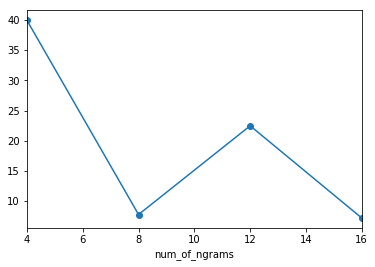

In [25]:
print("Average Coverage STD")
plt2 = df_average['Coverage STD'].plot(marker='o')
plt2.xaxis.set_major_locator(MaxNLocator(integer=True))

Coverage Percentage by Test Size


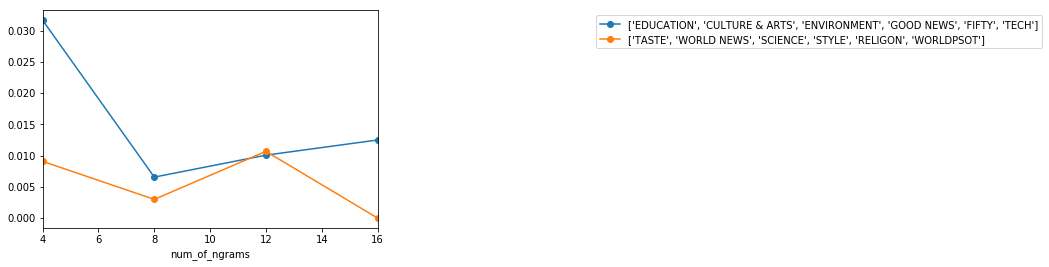

In [26]:
print("Coverage Percentage by Test Size")
plt3 = pd.pivot_table(data=df_test_size, 
               values="Coverage Percentage",
               columns="Labels",index="num_of_ngrams").plot(marker='o')
plt3.xaxis.set_major_locator(MaxNLocator(integer=True))
plt3.legend(loc='upper right',bbox_to_anchor=(3, 1))

Average Coverage Percentage


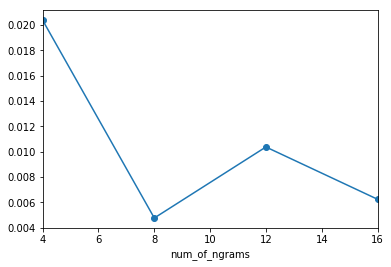

In [27]:
print("Average Coverage Percentage")
plt4 = df_average['Coverage Percentage'].plot(marker='o')
plt4.xaxis.set_major_locator(MaxNLocator(integer=True))

Correct Percentage by Test Size


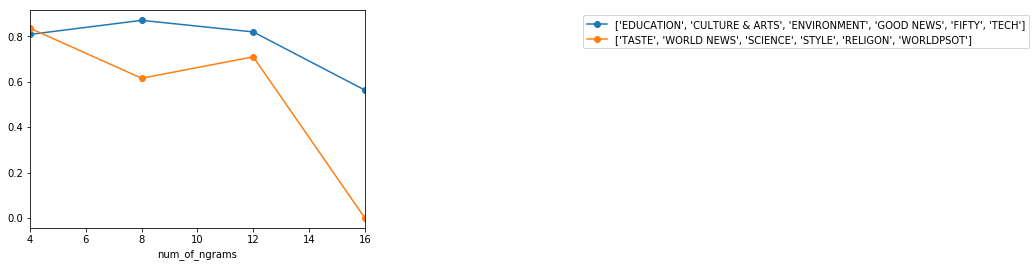

In [28]:
print("Correct Percentage by Test Size")
plt5 = pd.pivot_table(data=df_test_size, 
               values="Correct Percentage",
               columns="Labels",index="num_of_ngrams").plot(marker='o')
plt5.xaxis.set_major_locator(MaxNLocator(integer=True))
plt5.legend(loc='upper right',bbox_to_anchor=(3, 1))

Average Coverage Percentage


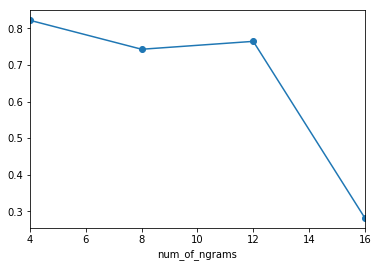

In [29]:
print("Average Coverage Percentage")
plt6 = df_average['Correct Percentage'].plot(marker='o')
plt6.xaxis.set_major_locator(MaxNLocator(integer=True))

In [26]:
# df_test_size.to_pickle("/Users/yayan/Desktop/df_test_size_4_good.pkl")

In [27]:
# import pickle


# with open('/Users/yayan/Desktop/df_test_size_4_good.pkl', 'rb') as f:
#     data = pickle.load(f)